In [1]:
#Import all of the necessary packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 10,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 10,
              }
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data

import mpld3
#sys.path.append("Z:\\Code\\PythonCode\\")
#import niceplot

C:\Users\Student\Anaconda2\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [4]:
dts = ddm.genLogDist(1,2998,400)

In [5]:
Fit_Results = {} #initialize once, you can keep all of the data in this pickle file and use it later

In [6]:
#load in the allResults file from the ddm anlaysis (the name of the videos)
Sample = ['ActinCopoly9.5fps_1','ActinCopoly9.5fps_2','ActinCopoly9.5fps_3'] 

In [7]:
#Set the frame rate and the dimensions
newt = lambda t,s: (1./s)*gamma(1./s)*t
framerate = 9.5
px = 0.196
imDimension = 256
q = np.arange(0,imDimension/2)*2*np.pi*(1./(imDimension*px))
times = dts/framerate

In [66]:
# This is the number of videos for each sample 
samNumber = ['1']#,'5','6','7','8']

In [67]:
# These are the ROIs used and saved in your pickle file
ROI = ['0','256','512']

In [68]:
# initialize this matrix: you will put all taus into this matrix from each video, 
# so make sure that you have more than enough rows to do so
tau_b = np.zeros([100,127])

In [69]:
# this sets which sample and which video is being read into the code
num =1 #the sample
ss = 0 #the video for the sample

In [82]:
#Load in the allResults file
#change the file and directory as needed
# data_dir = "Z:\\ChristelleSummer2018\\Data\\BeadsInConditions\\Copolymerized\\2018_07_17\\40\\copoly40fps_2\\"
# data_file ='AllResultsCopoly40fps_2.p'
data_dir = "Z:\\ChristelleSummer2018\\Data\\BeadsInConditions\\Copolymerized\\2018_08_07_75Actin\\2018_08_07_75Actin25Tub9.5fps_2\\"
data_file ='AllResults.p'
Ana_data = pickle.load(open(data_dir + data_file, 'r'))

In [83]:
Ana_data

{'chi20': array([0.00000000e+00, 2.83161188e+11, 1.20118395e+11, 6.71678355e+13,
        2.86534028e+12, 7.58264067e+13, 7.53524922e+13, 8.16101802e+13,
        6.45376614e+13, 5.65219203e+13, 5.79763274e+13, 6.21578119e+13,
        2.20378633e+09, 5.71380973e+13, 1.46917408e+09, 1.32018852e+09,
        8.50909638e+08, 6.31473167e+08, 5.86009450e+08, 7.89971618e+08,
        5.21851862e+08, 3.53516784e+08, 2.79602046e+08, 2.39725112e+08,
        1.70529169e+08, 1.33793777e+08, 1.16163823e+08, 9.81817542e+07,
        6.15913258e+07, 5.95139450e+07, 5.21701261e+07, 4.09985749e+07,
        2.55932291e+07, 2.71208492e+07, 1.73735887e+07, 1.71256499e+07,
        1.09526274e+07, 8.61734196e+06, 7.05403552e+06, 6.76230953e+06,
        4.78774370e+06, 4.64882860e+06, 3.66378857e+06, 3.54716279e+06,
        3.08889414e+06, 2.92916430e+06, 2.88818294e+06, 1.97249792e+06,
        2.26724885e+06, 1.56295225e+06, 1.85656491e+06, 1.43675925e+06,
        1.53167743e+06, 1.66740963e+06, 1.57909079e+06,

In [84]:
#This will plot all of the q vs tau for all of the ROIs in the   
tau = np.zeros([len(ROI),127]) #decay time: change the 63 10 127 if you are using 256 instead of 128
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
chi2 = np.zeros_like(tau)

for i in range(0,len(ROI)):
    fitparams = Ana_data['fitparams'+ROI[i]]
    tau[i,:] = fitparams[:,1]
    amp[i,:] = fitparams[:,0]
    bg[i,:] = fitparams[:,2]
    alph[i,:] = fitparams[:,3]
    print i

0
1
2


In [85]:
def DiffCoef (newtau_average, qrange, qmin, qmax):
    nt = newtau_average
    indx = np.where((q>=qmin)&(q<=qmax))
    print indx
    ds = (qrange[indx[0]]**-2.0) / nt[indx[0]]
    return ds.mean(), indx

def plot_results( qmin = q[2], qmax = q[10]):
    taus = ddm.newt(tau[chg,:], alph[chg,:])
    b = np.where((q>=qmin)&(q<=qmax))
    a = np.polyfit( np.log(q[b[0]]),np.log(taus[b[0]]), 1)
    slope = a[0]
    coef1 = np.exp(a[1])
    Dif = (1/coef1)
    alpha = 2./(-1*slope)
    print(alph[chg,10])
    ifDiff = DiffCoef(taus,q,qmin,qmax)
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    ax.loglog(q[1:-2], taus[1:-1], 'ro')
    ax.loglog(q[1:-2], coef1*(q[1:-2])**slope, '-k')
    ax.plot(q[1:-2], (1./ifDiff[0]) * 1./(q[1:-2]**2.0), '--k')
    ax.loglog(q[b[0]],taus[b[0]],'b.')
    ax.text(0.55,0.8,'D = %.4f' %Dif, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.text(0.22,0.8,'fixedD = %.4f' %ifDiff[0], 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.text(0.55,0.66,'slope = %.4f' %alpha, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.set_ylabel(" Tau", fontdict=font_plt_ax)

In [97]:
%matplotlib inline
mpld3.enable_notebook()
chg =2
# this is the index of tau_b that you will put your data into, 
            # make sure to not overwrite the data from the last video
interact(plot_results, qmin = (q[1],q[20]), qmax = (q[4],q[60]), continuous_update=False)
# keep track of the ROIs that are bad, you will do this in the excel sheet 
#because you will want to plot each video separately and it can be confusing

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMjUwNDQ1ODQyOTIwMTA0NywgZGVzY3JpcHRpb249dSdxbWluJywgbWF4PTIuNTA0NDU4NDI5MjAxMDQ2OCwgbWluPTDigKY=


<function __main__.plot_results>

In [98]:
# video save tau into tau_b
tau_b[chg,:] = ddm.newt(tau[chg],alph[chg]) #make sure to change the range that you put into the matrix or 
                            #you will overwrite your data and that will suck
                        # only save the taus that look ok
       

In [99]:
#Use this to check what components of tau_b have data in it
#tau_b[chg]
tau_b[chg]

array([           nan, 6.54314920e+01, 2.09182930e+04, 2.09182930e+04,
       1.91311162e+04, 1.91747713e+04, 2.09182930e+04, 2.09182930e+04,
       2.05272171e+04, 2.09182930e+04, 2.09182930e+04, 2.09182930e+04,
       1.26087851e+03, 4.41993287e+03, 1.77449210e+03, 1.17459162e+03,
       1.38866127e+03, 1.67475096e+02, 3.14880448e+02, 1.02111822e+02,
       9.45214228e+01, 7.83006075e+01, 5.61045106e+01, 6.36540591e+01,
       4.42497293e+01, 5.02616017e+01, 3.57541990e+01, 4.04049578e+01,
       3.08389597e+01, 2.66520753e+01, 2.62023892e+01, 2.36208406e+01,
       1.93746086e+01, 2.09570373e+01, 1.77017936e+01, 1.44598977e+01,
       1.30170502e+01, 1.03794794e+01, 1.07511389e+01, 1.19230829e+01,
       1.08342010e+01, 8.18645536e+00, 7.36472256e+00, 9.26899258e+00,
       6.09030355e+00, 7.48959363e+00, 6.55322730e+00, 7.66918878e+00,
       7.55737729e+00, 6.32837218e+00, 1.17926821e+01, 1.10872411e+01,
       7.34039970e+00, 1.01438071e+01, 3.60009447e+00, 4.73860803e+00,
      

In [100]:
Fit_Results

{'allTaus_ActinCopoly9.5fps_1': array([[           nan, 4.53878767e+01, 6.53336909e+02, ...,
         2.11236543e+04, 2.11236543e+04, 5.45473675e+01],
        [           nan, 5.22964935e+01, 2.80214408e+02, ...,
         8.45661951e+03, 6.45507385e+03, 5.12211693e+01],
        [           nan, 1.33346684e+04, 1.31995572e+04, ...,
         4.23569710e-04, 1.89349101e+04, 3.75966770e-04],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])}

In [101]:
Fit_Results['allTaus_'+Sample[num]] = tau_b #save this once you have finished all of the videos for the sample

In [102]:
#Once finished with the video, start over and do for the next (change ss)
#Once finished with the sample, fully start over changing num to 0 and ss to 0
#Reinitialize tau_b

In [103]:
Fit_Results

{'allTaus_ActinCopoly9.5fps_1': array([[           nan, 4.53878767e+01, 6.53336909e+02, ...,
         2.11236543e+04, 2.11236543e+04, 5.45473675e+01],
        [           nan, 5.22964935e+01, 2.80214408e+02, ...,
         8.45661951e+03, 6.45507385e+03, 5.12211693e+01],
        [           nan, 1.33346684e+04, 1.31995572e+04, ...,
         4.23569710e-04, 1.89349101e+04, 3.75966770e-04],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'allTaus_ActinCopoly9.5fps_2': array([[           nan, 2.62678802e+01, 1.80806769e+03, ...,
         4.27052875e+01, 3.58234775e+01, 2.14051590e+04],
        [           nan, 3.20768810e+01, 2.09244388e+04, ...,
         8.97615766e-

In [77]:
# After finishing the initial analysis and fitting you will want to plot tau v q for each video, 
# for all of the videos for the sample, and all of the samples together

Round2_Results={}

In [78]:
Round2_Results['allCopoly'] = Fit_Results

In [79]:
Round2_Results

{'allCopoly': {'allTaus_ActinCopoly9.5fps_1': array([[           nan, 4.53878767e+01, 6.53336909e+02, ...,
          2.11236543e+04, 2.11236543e+04, 5.45473675e+01],
         [           nan, 5.22964935e+01, 2.80214408e+02, ...,
          8.45661951e+03, 6.45507385e+03, 5.12211693e+01],
         [           nan, 1.33346684e+04, 1.31995572e+04, ...,
          4.23569710e-04, 1.89349101e+04, 3.75966770e-04],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])}}

In [86]:
pickle.dump(Round2_Results, open('Z:\ChristelleSummer2018\Data\AllResults\CopolyResultsAllVideos.p', 'wb'))

In [6]:
data_directory= 'Z:\\ChristelleSummer2018\\Data\\AllResults\\'

In [8]:
f = open(data_directory+'//CopolyResultsAllVideos.p','rb')
Round2_Results = pickle.load(f)
f.close()

KeyError: 'allTaus_Coppoly40fps_2'

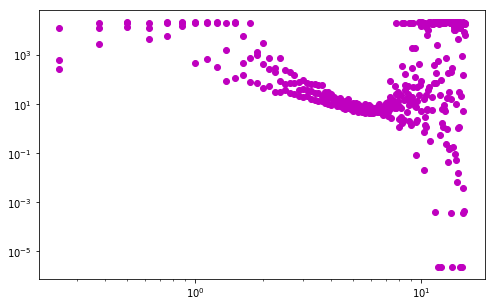

In [81]:
%matplotlib inline
mpld3.enable_notebook()

col = ['mo','co','yo']
#col = ['bo','bo','bo','bo']
fig,ax = plt.subplots(figsize=(8,8/1.618))
for i in range(0,4): ##for each video
    for j in range(len(ROI)): ##for each ROI
        if(i ==0):
            ax.loglog(q[2:-2], Round2_Results['allCopoly']['allTaus_ActinCopoly9.5fps_1'][j][2:-1], col[i])
        if(i ==1):
            ax.loglog(q[2:-2], Round2_Results['allCopoly']['allTaus_Coppoly40fps_2'][j][2:-1], col[i])
        if(i ==2):
            ax.loglog(q[2:-2], Round2_Results['allCopoly']['allTaus_Copoly9.5fps_1'][j][2:-1], col[i])
#         else:
#             ax.loglog(q[2:-2], Round2_Results['allCopoly']['allTaus_'+Sample[i]][j][2:-1], col[i])
plt.title('Copolymerized')
ax.set_xlim(1.5,8)
ax.set_ylim(0.3,30)
ax.loglog(q[1:-2], 60.0*(q[1:-2])**-2.70, '-k')
plt.savefig(data_directory+'CopolyPlots.png')

In [230]:
Round2_Results['allTausTubulin']['allTaus_AllResultsTub9.5fps_2'][2][2:-1]

array([1.76594553e+02, 2.59669175e+02, 9.95396389e+01, 3.51071146e+01,
       2.89423739e+01, 2.09756863e+01, 1.36377628e+01, 1.04881422e+01,
       7.05491794e+00, 6.29821657e+00, 4.94424159e+00, 4.08332388e+00,
       3.95176436e+00, 3.04280708e+00, 2.71856207e+00, 2.22901319e+00,
       1.99885596e+00, 1.80997190e+00, 1.59548031e+00, 1.44435894e+00,
       1.23104031e+00, 2.95820836e-01, 1.03379559e+00, 9.59685329e-01,
       8.59344782e-01, 7.68471398e-01, 7.17099449e-01, 6.26719945e-01,
       5.64645798e-01, 5.13820500e-01, 4.68362267e-01, 4.21420104e-01,
       3.78129671e-01, 3.81500050e-01, 3.07172132e-01, 3.33997037e-01,
       3.00016014e-01, 3.30396868e-01, 3.00156723e-01, 2.83734605e-01,
       3.12925142e-01, 4.02659600e-01, 2.33893306e-01, 2.86800657e-01,
       8.43611723e+01, 2.81530578e-01, 4.28383306e-01, 3.98678069e-01,
       2.86858564e+00, 4.95956573e+01, 1.80606025e+01, 2.00564823e-01,
       3.30468058e-01, 1.09736416e+00, 1.54506976e+00, 3.14812304e+02,
      

In [81]:
# tauB = Round2_Results['allTaus_Buffer']
# tauM = Round2_Results['allTaus_MT']
# tauC = Round2_Results['allTaus_Co']
# tau2 = Round2_Results['allTaus_Actin256_2']

# fig,ax = plt.subplots(figsize=(8,8/1.618))
# for i,j in enumerate(alC):
#     ax.loglog(q[1:-2], tauC[j,1:-1],  'bo', markersize = 3)
#     ax.plot(q[2:-2], (1./0.0074) * 1./(q[2:-2]**(2/0.554)), '-k')
# for i,j in enumerate(alB):
#     ax.loglog(q[1:-2], tauB[j,1:-1],  'ro', markersize = 3)
#     ax.plot(q[2:-2], (1./0.373) * 1./(q[2:-2]**(2/.974)), '-k')
# for i,j in enumerate(alM):
#     ax.loglog(q[1:-2], tauM[j,1:-1],  'go', markersize = 3)
#     ax.plot(q[2:-2], (1./0.0793) * 1./(q[2:-2]**(2/0.658)), '-k')
# for i,j in enumerate(al2):
#     ax.loglog(q2[1:-2], tau2[j,1:-1],  'mo', markersize = 3)
#     ax.plot(q2[2:-2], (1./0.0079) * 1./(q2[2:-2]**(2/0.59)), '-k')
# ax.set_ylabel(" Tau (s)", fontdict=font_plt_ax)
# ax.set_xlabel(r" q (rad/$\mu$m)", fontdict=font_plt_ax)
# plt.savefig("E:\\AllData_Results\\All_All.png")

In [120]:
Round2_Results['Actin_256_average_newtau'] = taus
Round2_Results['Actin_256_std_newtau'] = taustd

In [121]:
pickle.dump(Round2_Results, open('E:\\AllData_Results\\Actin_256x256.p','wb'))

In [126]:
#Ana_data.keys()

In [541]:
#pickle.dump(Round2_Results, open('E:\\AllData_Results\\AllConditions_results.p','wb'))

In [125]:
#Round2_Results.keys()

ValueError: x and y must have same first dimension, but have shapes (60L,) and (124L,)

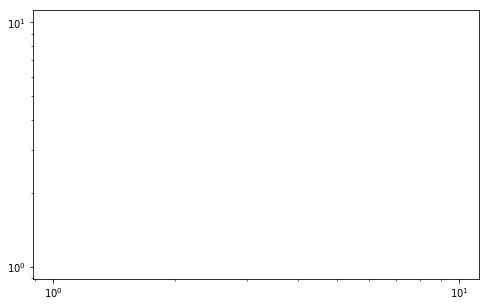

In [127]:
%matplotlib inline
mpld3.enable_notebook()

a = ['Dilute','MT','Actin','Copoly']
cc = ['ro', 'bo','go','mo']
diffusionCo = [0.309,0.039,0.0037,0.0031]


fig,ax = plt.subplots(figsize=(8,8/1.618))
for i in range(4):
    taus = Ana_data[a[i]+'_average_newtau']
    ax.loglog(taus,(2*np.pi)/q[3:-1],  cc[i])
ax.set_ylim(1.0,11)
#plt.savefig('E:\\AllData_Results\\AllConditions.svg')

    #ax.plot((1./diffusionCo[i]) * 1./(q[5:-42]**slope[i]), (2*np.pi)/q[5:-42],  '-k')


for i in range(4):
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    taus = Ana_data[a[i]+'_average_newtau']
    ax.loglog(taus,(2*np.pi)/q[3:-1],  cc[i])
    ax.plot((1./0.1) * 1./(q[2:-42]**2.0), (2*np.pi)/q[2:-42],  '-k')
    ax.set_ylim(1.0,11)
    #plt.savefig('E:\\AllData_Results\\'+a[i]+'Condition.svg')
    
    #ax.errorbar(q[3:-30],taus[:-29],yerr=taustd[:-29],fmt=cc[i], elinewidth = 1.3, capsize=2)

In [335]:
DC_roi[chg] = 0.24
a_roi[chg] = 2/2.4

In [314]:
Round2_Results['Diffusion1'+Sample2[num]+'_'+samNumber[0]] = DC_roi
Round2_Results['Diffusion2'+Sample2[num]+'_'+samNumber[1]] = DC_roi2
Round2_Results['alpha1'+Sample2[num]+'_'+samNumber[0]] = a_roi
Round2_Results['alpha2'+Sample2[num]+'_'+samNumber[1]] = a_roi2

In [273]:
Round2_Results['newTaus_ROIs'+Sample2[num]+'_'+samNumber[ss]] = ntav
Round2_Results['newTausSTD_ROIs'+Sample2[num]+'_'+samNumber[ss]] = ntstd

In [180]:
pickle.dump(Round2_Results, open('Z:\\Devynn_Summer2018\\Data\\AllData_Results\\Round2_Results_BufferConditions_withoutDiffCoeffs_all.p','wb'))

In [421]:
ntav.shape

(31L,)

In [217]:
R1 = np.zeros([len(ROI),2])
R2 = np.zeros([len(ROI),2])

(0.9, 15)

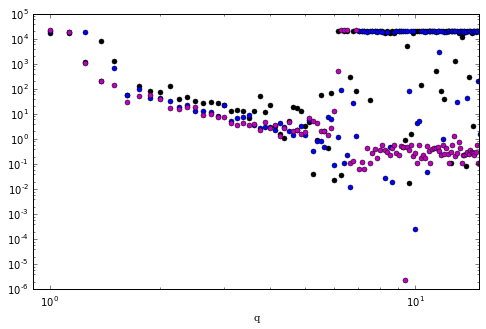

In [36]:
%matplotlib inline
mpld3.enable_notebook()
V = ['top', 'bottom']
z = 0

ROI = ['0', '256', '512']
#This will plot all of the q vs tau for all of the ROIs in the   
tau = np.zeros([len(ROI),127]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
chi2 = np.zeros_like(tau)
#fitparams = np.zeros([63,7])
for i in range(len(ROI)):
    fitparams = Ana_data['fitparams_'+ROI[i]]
    tau[i,:] = fitparams[:,1]
    amp[i,:] = fitparams[:,0]
    bg[i,:] = fitparams[:,2]
    alph[i,:] = fitparams[:,3]

fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.set_xlabel("q", fontdict=font_plt_ax)

nt = np.zeros([len(ROI),31])
cols = ['ko','bo','mo','go','co','yo','ro','gv','bv','mv']
for i in range(len(ROI)):
    ax.loglog(q[3:-1], ddm.newt(tau[i,2:-1], alph[i,2:-1]), cols[i], ms= 5.0)

ntav = np.mean(nt, axis=0)
ntstd = np.std(nt,axis=0)

#ax.loglog(q[3:-30], ntav, 'rv')
ax.set_xlim(0.9,15)

['newTaus_ROIsallResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_2',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_1',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_2',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_2',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_1',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_8000frames_1',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_2',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_1',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_8000frames_2',
 'newTaus_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_1',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_2',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_1',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_8000frames_1',
 'newTausSTD_ROIsallResults_0.02mgmlDNA_Buffer_99fps_10exp_2',
 'newTausSTD_

In [518]:
#ToKeep.keys()

After averaging each of the ROIs: average together the videos and get a diffusion coefficient for each video and then for the average

In [182]:
Condition = pickle.load(open('Z:\\Devynn_Summer2018\\Data\\AllData_Results\\Round2_Results_BufferConditions_withoutDiffCoeffs_all.p','rb'))
Smps = ['allResults_0.02mgmlDNA_CoNetwork_29fps_34exp','allResults_0.02mgmlDNA_MTNetwork_29fps_34exp','allResults_0.02mgmlDNA_ActinNetwork_29fps_34exp']

In [183]:
SS =['allResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_1','allResults_0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames_2', 
     'allResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_1','allResults_0.02mgmlDNA_Buffer_49fps_20exp_8000frames_2',
     'allResults_0.02mgmlDNA_Buffer_99fps_10exp_8000frames_1','allResults_0.02mgmlDNA_Buffer_99fps_10exp_8000frames_2',
     'allResults_0.02mgmlDNA_Buffer_99fps_10exp_1','allResults_0.02mgmlDNA_Buffer_99fps_10exp_2']

In [317]:
DC_roi = np.zeros(len(ROI))
a_roi = np.zeros(len(ROI))
DC_roi2 = np.zeros(len(ROI))
a_roi2 = np.zeros(len(ROI))

In [185]:
#Condition.keys()

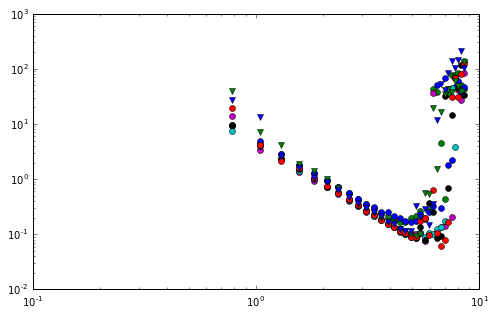

In [187]:
%matplotlib inline
mpld3.enable_notebook()

samNumber = ['1', '2']
ROI = ['0', '128', '256', '384','512', '640','768','896']
#['1_top','1_bottom','2_top','2_bottom','4_top','6_top','6_bottom','7_top','8_top','8_bottom']
theone = 0
tau = np.zeros([len(SS),31])
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca();
col = ['go', 'bo', 'mo', 'co','ko', 'ro','gv','bv','mv','cv','kv','rv']
for i in range(len(SS)):
    tau[i] = Condition['newTaus_ROIs'+SS[i]]
    std = Condition['newTausSTD_ROIs'+SS[i]]
    ax.loglog(q[3:-30],tau[i], col[i])
tauAVG = np.mean(tau,axis=0)
tauSTD = np.std(tau,axis=0)

In [188]:
DC = np.zeros(len(SS))
Sa = np.zeros(len(SS))

In [87]:
b = np.where((q>=0.7)&(q<=1.7))
b

(array([3, 4, 5, 6], dtype=int64),)

In [85]:
b = np.where((q>=0.6)&(q<=2.7))
a = np.polyfit( np.log(q[b[0]]),np.log(tauB[0,b[0]]), 1)
slope = a[0]
coef1 = np.exp(a[1])

print(a)
fig,ax = plt.subplots(figsize=(8,8/1.618))
ax.loglog(q[1:-2],tauB[0,1:-1],'ro')
ax.loglog(q[1:-2], coef1*(q[1:-2])**slope, '-k')
ax.loglog(q[b[0]],tauB[0,b[0]],'b.')

NameError: name 'tauB' is not defined

In [ ]:
fits = Diff_Fit(q[2:30],tauB[2:30],q[3],q[10],alph[2:30])

In [89]:
def DiffCoef (newtau_average, qrange, qmin, qmax):
    nt = newtau_average
    indx = (qrange>qmin) & (qrange<qmax)
    ds = (qrange[indx]**-2) / nt[indx]
    return ds.mean(), indx

def Diff_Fit(qrange, taurange, qmin, qmax, StExp, slope):
    step1 = DiffCoef(taurange, StExp, qrange, qmin, qmax)
    fit1 = (1./step1[0]) * 1./(step1[1]**slope)
    return fit1, step1[0], step1[1]

#Need to fix the function so the it will fit the data

#define a function to plot the results

def plot_results(qmin = q[2], qmax = q[10], slope = 2.0):
    qs = q[3:-30]
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    ax.loglog(qs, tauB, 'ro')
    #ax.errorbar(np.log(qs),np.log(tauAVG), yerr = tauSTD, xerr = None, fmt = 'ro')
    fits = Diff_Fit(qs, tauB, qmin, qmax, alph[2:-30], slope)
    ax.loglog(qs,fits[0],'-k')
    #ax.plot(np.log(qs), np.log(fits[0]),  '-k')
    #ax.set_ylim(-2.0,10)
    ax.text(0.55,0.8,'D = %.3f' %fits[1], 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.text(0.55,0.77,'slope = %.2f' %slope, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.set_ylabel(" Tau", fontdict=font_plt_ax)

def roughEstimate (diffusionCo = 0.3, slope = 2.0):
    tauB
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    ax.loglog(q[3:-30], tau[0], 'ro')
    ax.plot(q[3:-42], (1./diffusionCo) * 1./(q[3:-42]**slope), '-k')
    ax.text(0.55,0.8,'D = %.4f' %diffusionCo, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.text(0.55,0.77,'slope = %.2f' %slope, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.set_ylabel(" Tau", fontdict=font_plt_ax)



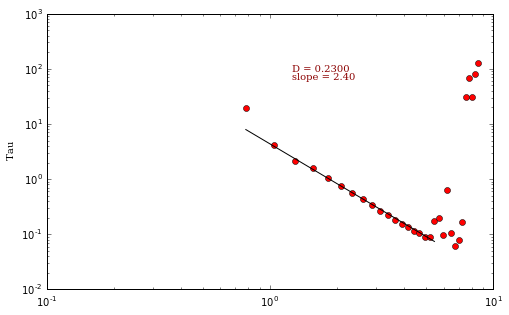

In [213]:
chg = 5
interact(roughEstimate, diffusionCo = (0.05,0.5,0.005), slope = (2.0,4.5,0.05), continuous_update=False)

In [214]:
DC[chg] = 0.3
Sa[chg] = 2/2.25 #this is alpha = 2/slope

In [215]:
AlSTD = np.std(Sa, axis=0)
DCstd = np.std(DC,axis=0)
Alavg = np.mean(Sa, axis=0)
DCavg = np.mean(DC,axis=0)
DCavg, DCstd, Alavg, AlSTD   

(0.25918749999999996,
 0.056354867524908626,
 0.87932983862678593,
 0.049956304206211076)

In [212]:
Sa

array([ 0.88888889,  0.85106383,  0.86956522,  0.86956522,  0.83333333,
        0.        ,  1.        ,  0.83333333])

In [101]:
ToKeep['DiffCoef_fromAVG_'+Smps[theone]] = DCavg
ToKeep['DiffCoefSTD_'+Smps[theone]] = DCstd
ToKeep['Alpha_fromAVG_'+Smps[theone]] = Alavg
ToKeep['AlphaSTD_'+Smps[theone]] = AlSTD
ToKeep['TauAverage_'+Smps[theone]] = tauAVG
ToKeep['TauSTD_'+Smps[theone]] = tauSTD

NameError: global name 'alph' is not defined

<function __main__.plot_results>

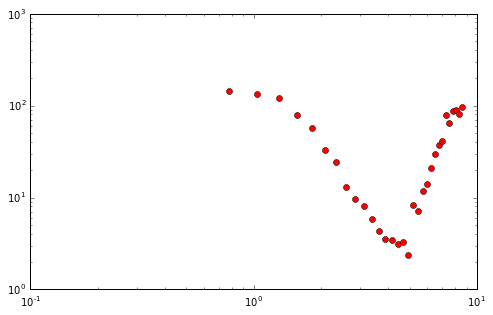

In [36]:
#fit to the high q region
interact(plot_results, qmin = (q[0], q[10]), qmax = (q[5], q[20]), slope = (2.0,4.5,0.05), continuous_update=False)

In [534]:
pickle.dump(ToKeep, open('Z:\\Devynn_Summer2018\\Data\\AllData_Results\\ToKeep_maybeallbad.p', 'wb'))

In [527]:
DiffCoef_average1 = 0.016
DiffCoef_averageAlpha1 = 2/2.00

In [495]:
def plot_resultsall(qmin = q[2], qmax = q[10], slope = 2.0):
    qs = q[3:-30]
    tau = Condition['newTaus_ROIs'+Smps[theone]+'_'+samNumber[chg]]
    std = Condition['newTausSTD_ROIs'+Smps[theone]+'_'+samNumber[chg]]
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    ax.errorbar(np.log(qs),np.log(tau), yerr = std, xerr = None, fmt = 'ro')
    fits = Diff_Fit(qs, tau, qmin, qmax, alph[2:-30], slope)
    ax.plot(np.log(qs), np.log(fits[0]),  '-k')
    ax.set_ylim(-2.0,10)
    ax.text(0.55,0.8,'D = %.3f' %fits[1], 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.text(0.55,0.77,'slope = %.2f' %slope, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)
    ax.set_ylabel(" Tau", fontdict=font_plt_ax)
    ax.set_xlabel(" q", fontdict=font_plt_ax)
    ax.set_title(Smps[theone]+'_'+samNumber[chg], fontdict=font_plt_ax)

In [84]:
#fit for each video used in the average to get a standard deviation

interact(plot_resultsall, qmin = (q[0], q[10]), qmax = (q[5], q[20]), slope = (2.0,4.5,0.05), continuous_update=False)

NameError: name 'plot_resultsall' is not defined